In [ ]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne
import os
from tqdm import tqdm

from scipy.stats import kurtosis, skew

from typing import List, Tuple

from mne.io import read_raw_eeglab

In [ ]:
input_fnames = {
    "pre": [
        "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_pre1_RELAX.set",
        "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_pre2_RELAX.set",
        "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_pre3_RELAX.set",
    ],
    "break": [
        "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_RELAX.set",
        "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_RELAX.set",
    ],
    "post": [
        "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur1_post1_RELAX.set",
        "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur2_post2_RELAX.set",
        # "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_RELAX.set",
        "/Users/soroush/Documents/Code/freelance-project/vielight/vielight_close_loop/data/HD_5min40Hz_dur3_post3_part2_RELAX.set",
    ],
}

epoch_length = 5
overlap = 0.3
eog = ()

pre_raws = []
for input_fname in input_fnames["pre"]:
    raw = read_raw_eeglab(
        input_fname=input_fname,
        eog=eog,
        preload=True,
        montage_units="mm",
        verbose=True,
    )
    raw.rename_channels(lambda x: x.strip("."))
    raw.rename_channels(
        mapping={
            "FPZ": "Fpz",
            "OZ": "Oz",
            "FP1": "Fp1",
            "FP2": "Fp2",
            "FZ": "Fz",
            "FCZ": "FCz",
            "CPZ": "CPz",
            "PZ": "Pz",
            "POZ": "POz",
        }
    )
    raw.drop_channels(["FT11", "F12", "F11"])
    montage = mne.channels.make_standard_montage("standard_1020")
    raw.set_montage(montage)
    pre_raws.append(raw)

post_raws = []
for input_fname in input_fnames["post"]:
    raw = read_raw_eeglab(
        input_fname=input_fname,
        eog=eog,
        preload=True,
        montage_units="mm",
        verbose=True,
    )
    raw.rename_channels(lambda x: x.strip("."))
    # ['FP1', 'FP2', 'FZ', 'FCZ', 'CPZ', 'PZ', 'POZ'].
    raw.rename_channels(
        mapping={
            "FPZ": "Fpz",
            "OZ": "Oz",
            "FP1": "Fp1",
            "FP2": "Fp2",
            "FZ": "Fz",
            "FCZ": "FCz",
            "CPZ": "CPz",
            "PZ": "Pz",
            "POZ": "POz",
        }
    )
    raw.drop_channels(["FT11", "F12", "F11"])
    montage = mne.channels.make_standard_montage("standard_1020")
    raw.set_montage(montage)
    post_raws.append(raw)

len(pre_raws), len(post_raws)

In [ ]:
# First we need to calculate the psd of each raw data

raw = pre_raws[2]

method = "welch"  # for raw data
fmin, fmax = 0, np.inf
tmin, tmax = None, None  # for all data ttme
picks = None
proj = True  # no projection
remove_dc = False  # no remove dc, since dc is already removed
reject_by_annotation = True  # we don't have annotataion here
n_jobs = -1
verbose = True
normalize = (True,)


spectrum = raw.compute_psd(
    method=method,
    fmin=fmin,
    fmax=fmax,
    tmin=tmin,
    tmax=tmax,
    picks=picks,
    n_jobs=n_jobs,
    reject_by_annotation=reject_by_annotation,
    verbose=verbose,
    # normalize=normalize,
)

bands = None  # None, or dict with keys 'delta', 'theta', 'alpha', 'beta', 'gamma'
ch_type = "eeg"
normalize = False
dB = True  # convert to dB
sensors = True
outlines = "head"
sphere = "eeglab"
extrapolate = "head"
show_names = False


spectrum.plot_topomap(
    bands=bands,
    ch_type=ch_type,
    dB=dB,
    sensors=sensors,
    outlines=outlines,
    sphere=sphere,
    extrapolate=extrapolate,
    show_names=show_names,
)
plt.show()

In [ ]:
# First we need to calculate the psd of each raw data

raw = post_raws[2]

method = "welch"  # for raw data
fmin, fmax = 0, np.inf
tmin, tmax = None, None  # for all data ttme
picks = None
proj = True  # no projection
remove_dc = False  # no remove dc, since dc is already removed
reject_by_annotation = True  # we don't have annotataion here
n_jobs = -1
verbose = True

spectrum = raw.compute_psd(
    method=method,
    fmin=fmin,
    fmax=fmax,
    tmin=tmin,
    tmax=tmax,
    picks=picks,
    n_jobs=n_jobs,
    reject_by_annotation=reject_by_annotation,
    verbose=verbose,
)

bands = None  # None, or dict with keys 'delta', 'theta', 'alpha', 'beta', 'gamma'
ch_type = "eeg"
normalize = False
dB = True  # convert to dB
sensors = True
sphere = "eeglab"
show_names = False


spectrum.plot_topomap(
    bands=bands,
    ch_type=ch_type,
    normalize=normalize,
    dB=dB,
    sensors=sensors,
    sphere=sphere,
    show_names=show_names,
)
plt.show()

In [ ]:
def create_manual_events(
    start_time, event_duration, overlap, signal_length, event_id=1, sfreq=1000
):
    """
    Create manual events for an EEG signal.

    Parameters
    ----------
    start_time : float
        The start time in seconds for the first event.
    event_duration : float
        The duration of each event in seconds.
    overlap : float
        The overlap between consecutive events in seconds.
    signal_length : float
        The total length of the signal in seconds.
    event_id : int
        The event ID to assign to each event (default is 1).
    sfreq : float
        The sampling frequency of the signal in Hz (default is 1000 Hz).

    Returns
    -------
    events : np.ndarray
        Array of events with shape (n_events, 3).
    """

    # Calculate the time step for each event considering overlap
    time_step = event_duration - overlap

    # Generate event times
    event_times = np.arange(start_time, signal_length, time_step)

    # Convert event times to sample indices
    event_samples = (event_times * sfreq).astype(int)

    # Create events array
    events = np.column_stack(
        (
            event_samples,
            np.zeros_like(event_samples, dtype=int),
            np.full_like(event_samples, event_id, dtype=int),
        )
    )

    return events


# Example usage
start_time = 10  # start at 10 seconds

pre_epochs = []
for raw in pre_raws:
    event_id = {"pre": 1}
    event_duration = raw.times[-1]  # each event lasts 5 second
    overlap = 0  # 0 seconds overlap between events
    signal_length = raw.times[-1]
    sfreq = raw.info["sfreq"]

    events = create_manual_events(
        start_time, event_duration, overlap, signal_length, event_id=1, sfreq=sfreq
    )
    tmin = 0
    tmax = raw.times[-1] - 10

    epoch = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=(0, 0), preload=True)

    pre_epochs.append(epoch)


post_epochs = []
for raw in post_raws:
    event_id = {"post": 2}
    event_duration = raw.times[-1]  # each event lasts 5 second
    overlap = 0  # 0 seconds overlap between events
    signal_length = raw.times[-1]
    sfreq = raw.info["sfreq"]

    events = create_manual_events(
        start_time, event_duration, overlap, signal_length, event_id=2, sfreq=sfreq
    )
    tmin = 0
    tmax = raw.times[-1] - 10

    epoch = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=(0, 0), preload=True)

    post_epochs.append(epoch)

In [ ]:
pre_epochs[0].get_data().shape, post_epochs[0].get_data().shape

/var/folders/r3/bw3cwm6125lcm5h39987hgz80000gn/T/ipykernel_31552/135524371.py:8: RuntimeWarning: More than 25 topomaps plots requested. This might take a while.
  evoked.plot_topomap(


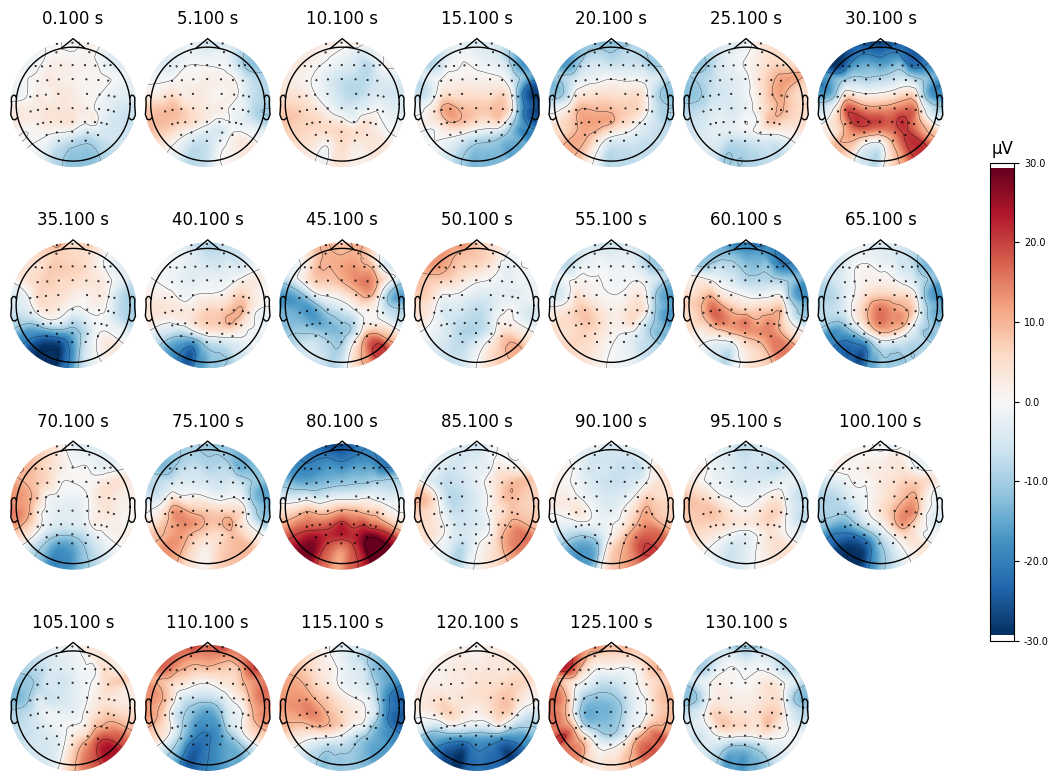

In [173]:
# Average the epochs to get evoked data
index_data = 0
evoked = pre_epochs[index_data].average()

all_times = np.arange(0.1, evoked.times[-1], 5)


evoked.plot_topomap(
    times=all_times,
    ch_type="eeg",
    time_unit="s",
    image_interp="cubic",
    extrapolate="head",
    ncols=7,
    nrows="auto",
)
plt.show()

In [ ]:
all_times = np.arange(0.1, evoked.times[-1], 5)
fig, anim = evoked.animate_topomap(
    times=all_times, ch_type="eeg", frame_rate=2, blit=False, image_interp = "cubic", extrapolate = "head", 
)
anim.save("evoked_topomap.gif", writer="imagemagick", fps=2)